In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import ClassificationSingleLayerMDN, Trainer, UnivariateMogMDN
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 15,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

In [3]:
folder = '../data/'
fn = '201803151541_toy_example_results_N10000M10_k220.0.p'

with open(os.path.join(folder, fn), 'rb') as f: 
    d = pickle.load(f)

In [4]:
d_model = d['model_post']
d_model.keys()

dict_keys(['seed', 'trainer', 'model_models', 'x', 'm', 'xtest', 'mtest', 'sx', 'sx_test', 'training_norm', 'param_poi', 'params_nb', 'theta1', 'theta2', 'theta3', 'k1', 'k2', 'k3', 'sample_size', 'n_samples', 'ppoi_exact'])

In [5]:
model = d_model['model_models']
x = d_model['x']
sx = d_model['sx']
xtest = d_model['xtest']
mtest = d_model['mtest']
ppoi_exact = d_model['ppoi_exact']
sx_test = d_model['sx_test']

training_norm = d_model['training_norm']
k1, k2, k3 = d_model['k1'], d_model['k2'], d_model['k3']
theta1, theta2, theta3 = d_model['theta1'], d_model['theta2'], d_model['theta3']

## Validation the posterior 

The checks are used to validate the posterior of the parameter given the data that was learned. In this case we also know the ground truth, therefore, we have the possibility the validate the predicted posterior probabilities directly as well. 

For the validation we use a testing data set, $N_{test}$ number of parameters drawn from the prior, and simulated forward to give testing data $X_{test}$. 

### MSE to ground truth posterior 
To evaluate the posterior probabilities directly we just calculate the mean squared error between the predicted and the exact posterior probabilities. For every data sample in $X_{test}$ we calculate the squared error and then we take the mean over test samples. 

### Posterior quantiles
To do the quantile checks, we perform the following steps: 
    - for every test sample obtain the posterior 
    - calculate the quantile of the corresponding test parameter in the posterior distribution 

This gives $N_{test}$ quantile values. According to the paper the distribution underlying these quantile is uniform if the posterior is accurate. A first visual test is therefore to plot the histogram of quantiles and check whether it is uniform. As a next step one could perform statistical tests to test the uniformity of the empirical quantile distribution. 

### Coverage analysis: credible intervals of the quantile distribution 
Alternatively, and somehow more Bayesian, is to check the credible intervals of the quantile distribution. To this end, we count the mass in different intervals around the mode of the distribution, or, assuming that the quantile distribution is uniform in $[0, 1]$, around 0. Then we compare this mass against the width of the interval, e.g., plot the interval against the counted mass. For a perfectly uniform distribution this would be a straight line because the mass is distributed uniformly so that it exactly matches the width of the interval. In summary: 
     - count the relative number of quantiles in intervals of $0.1, \ldots, 0.5$ arond 0 of the quantile histogram
     - plot the relative counts against the width of the interval

# First the discrete model idx posterior

## Visualize network and test samples

### Calculate grid of predictions 

In [6]:
ms, vs = np.meshgrid(np.linspace(0, 1000, 100), np.linspace(0, 1000, 100))
# stack values to evaluate as vector in the model 
sx_vis = np.vstack((ms.flatten(), vs.flatten())).T
# normalize 
sx_vis, training_norm = normalize(sx_vis, training_norm)


# predict probs 
ppoi_vec = model.predict(sx_vis)
# take poisson posterior prob and reshape to grid dimensions
ppoi_vismat = ppoi_vec[:, 0].reshape(ms.shape[0], vs.shape[0])

### Plot exact posterior probs on top

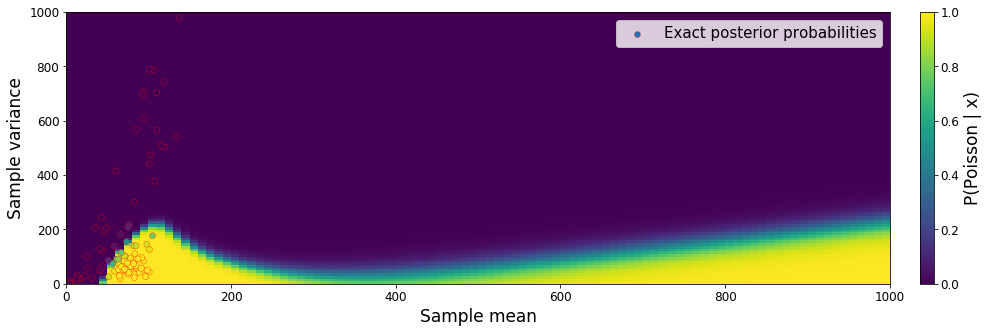

In [7]:
plt.figure(figsize=(18, 5))
cnorm = mpl.colors.Normalize(vmin=ppoi_vismat.min(), vmax=ppoi_vismat.max())
cmap = plt.cm.viridis

plt.scatter(x=sx_test[:, 0], y=sx_test[:, 1], c=np.array(ppoi_exact), cmap=cmap, norm=cnorm, edgecolors='r', linewidths=0.3)

plt.imshow(ppoi_vismat, origin='lower', aspect='auto', 
           norm=cnorm, cmap=cmap, extent=[ms.min(), ms.max(), vs.min(), vs.max()])

plt.xlabel('Sample mean')
plt.ylabel('Sample variance')
plt.colorbar(label='P(Poisson | x)', pad=0.03)
plt.legend(['Exact posterior probabilities'], frameon=True);

# MSE 

In [8]:
sx_test_zt, training_norm = normalize(sx_test, training_norm)
ppoi_hat = model.predict(sx_test_zt)[:, 0]
mse = np.mean(np.abs(ppoi_hat - ppoi_exact))
print('MAE', mse)

MAE 0.026588040121926095


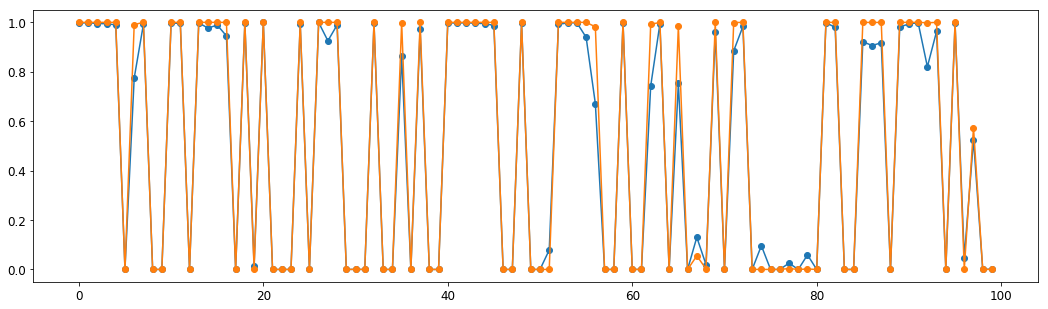

In [9]:
plt.figure(figsize=(18, 5))
plt.plot(ppoi_exact, 'o-')
plt.plot(ppoi_hat, 'o-');

# Quantiles

- for every test sample obtain the posterior 
- calculate the quantile of the corresponding test parameter in the posterior distribution 
    - the test parameter is actually the true model

In [10]:
qis = np.ones_like(np.array(mtest)).astype(float)
# normalize test data 
sx_test_zt, _ = normalize(sx_test, training_norm)
# get posteriors 
posteriors = model.predict(sx_test_zt)
# get probability for m=1
p_m1s = posteriors[:, 1]

In [11]:
# calculate quantiles 
m1_mask = np.array(mtest) == 1
qis[m1_mask] = 1. - p_m1s[m1_mask]

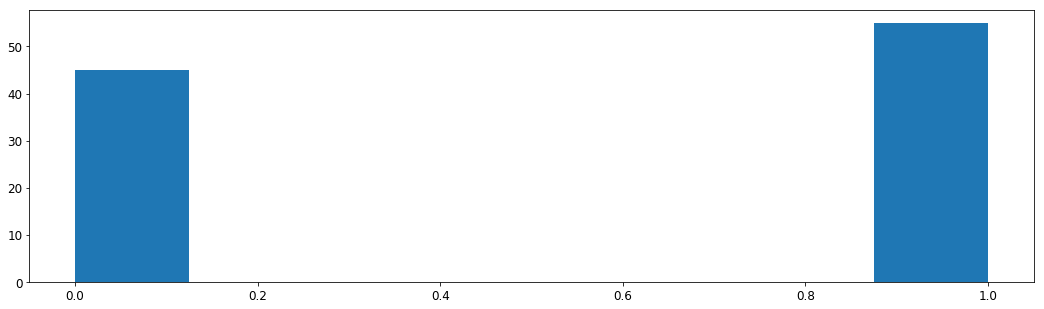

In [12]:
plt.hist(qis, bins='auto');

# Now the continuous model parameter posterior

In [13]:
d_param_posterior = d['param_post']
d_param_posterior.keys()

dict_keys(['seed', 'trainer', 'params_mdn', 'x', 'y', 'sx', 'x_test', 'sx_test', 'y_test', 'training_norm', 'prior_norm', 'theta1', 'theta2', 'theta3', 'k1', 'k2', 'k3', 'sample_size', 'n_samples'])

In [14]:
params_posterior_mdn = d_param_posterior['params_mdn']
training_norm = d_param_posterior['training_norm']
prior_norm = d_param_posterior['prior_norm']
seed = d_param_posterior['seed']
sample_size = d_param_posterior['sample_size']

In [15]:
x_test = d_param_posterior['x_test']
params_test = d_param_posterior['y_test']
ntest = params_test.size

## Sample new test data 

In [16]:
ntest = 10000
seed_test = 2
np.random.seed(seed_test)
prior_lambda = scipy.stats.gamma(a=k1, scale=theta1)
params_test = prior_lambda.rvs(size=ntest)
poisson_model = PoissonModel(sample_size=sample_size, seed=seed_test, n_workers=1)
x_test = poisson_model.gen(params_test)

In [17]:
sx_test = calculate_stats_toy_examples(x_test)
sx_test_zt, _ = normalize(sx_test, training_norm)
params_test_zt, _ = normalize(params_test, prior_norm)

## Calculate Quantiles

In [18]:
qis = np.zeros(ntest)
# for every test sample 
for ii, (thetao_i, sxo_i) in enumerate(zip(params_test_zt, sx_test_zt)): 
    
    # predict the posterior
    posterior = params_posterior_mdn.predict(sxo_i.reshape(1, -1))
    
    # get quantile of theta_o
    qis[ii] = posterior.get_quantile(thetao_i)

## Check Quantiles for Uniformity

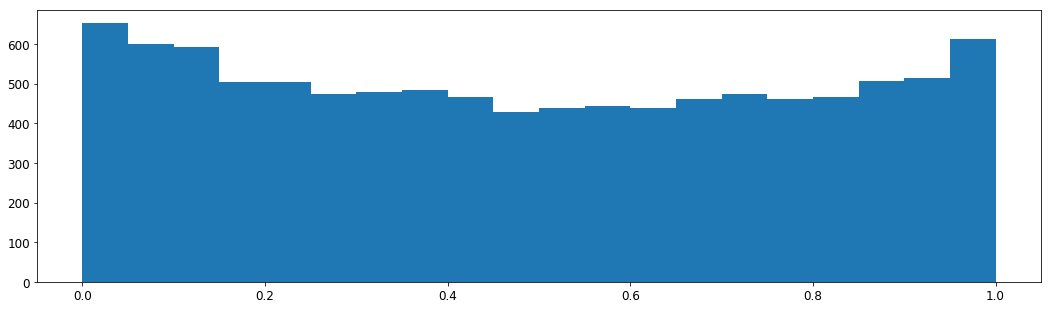

In [19]:
n, bins, patches = plt.hist(qis, bins='auto');

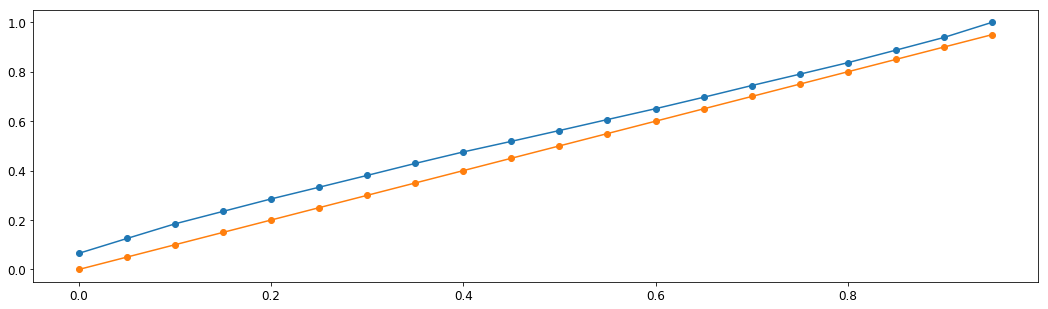

In [20]:
n /= np.sum(n)
plt.plot(bins[:-1], np.cumsum(n), 'o-')
plt.plot(bins[:-1], bins[:-1], 'o-');

In [21]:
scipy.stats.kstest(qis, cdf='uniform')

KstestResult(statistic=0.03644115695811037, pvalue=5.841630117360898e-12)